##  Import

In [6]:
import os
import gc
import random
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from datetime import datetime
from scipy import sparse
from scipy.sparse import csr_matrix
from ipywidgets import interact
from IPython.display import Image

# Surprise Imports
from surprise import Reader, Dataset
from surprise import BaselineOnly 
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp

# Scikit-Learn Imports
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

# Configuration
# matplotlib.use('nbagg')
# plt.rcParams.update({'figure.max_open_warning': 0})
sns.set_style('whitegrid')

# EDA

## 2.1 Load Data 

In [33]:
start = datetime.now()
if not os.path.isfile('./data.csv'):
    # Create a file 'data.csv' before reading it
    # Read all the files in the dataset and store them in one big file ('data.csv')
    # We're reading from each of the four files and appending each rating to a global file 'data.csv'
    data = open('data.csv', mode='w')
    
    row = list()
    files = [
        './combined_data_1.txt',
        './combined_data_2.txt', 
        './combined_data_3.txt', 
        './combined_data_4.txt'
    ]
    for file in files:
        print("Reading ratings from {}\n".format(file))
        with open(file) as f:
            for line in f: 
                line = line.strip()
                if line.endswith(':'):
                    # All below are ratings for this movie, until another movie appears.
                    movie_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movie_id)
                    data.write(','.join(row))
                    data.write('\n')
    data.close()
print('Time taken :', datetime.now() - start)

Reading ratings from .\combined_data_1.txt

Reading ratings from .\combined_data_2.txt

Reading ratings from .\combined_data_3.txt

Reading ratings from .\combined_data_4.txt

Time taken : 0:08:20.487364


In [34]:
# print("Creating the dataframe from data.csv file")
df = pd.read_csv('./data.csv', sep=',', 
    names=['movie', 'user', 'rating', 'date'])
df.date = pd.to_datetime(df.date)

# We are arranging the ratings according to time-stamp(s)
print('Sorting the dataframe by Date')
df.sort_values(by='date', inplace=True)
print('Done')

Sorting the dataframe by Date
Done


In [35]:
df.head()

,movie,user,rating,date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11


In [ ]:
df.describe()['rating']

count    1.004805e+08
mean     3.604290e+00
std      1.085219e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

### 2.1.1 Checking for NaN values

In [ ]:
# Just to make sure that all Nan containing rows are deleted
print("No of Nan values in our dataframe: ", sum(df.isnull().any()))

No of Nan values in our dataframe:  0


### 2.1.2 Removing Duplicates

In [ ]:
# By considering all columns, including timestamp
dup_bool = df.duplicated(['movie','user','rating'])
dups = sum(dup_bool) 
print("There are {} duplicate rating entries in the data".format(dups))

There are 0 duplicate rating entries in the data


### 2.1.3 Basic Statistics (#Ratings, #Users, and #Movies)

In [63]:
total_users = len(np.unique(df.user))
total_movies = len(np.unique(df.movie))

print("Total No of Ratings:", df.shape[0])
print("Total No of Users  :", total_users)
print("Total No of movies :", total_movies)

# Removing the original dataframe from RAM
del df
gc.collect()

Total No of Ratings: 100480507
Total No of Users  : 480189
Total No of movies : 17770


7862

## 2.2 Spliting data into Train and Test (80:20)
- Since, the data that we have been given has a **temporal structure**, i.e., the ratings given to the movies by the users change over time, hence, we will prefer time-based splitting over random splitting. 
- Thankfully, we have been given the timestamp(s), so, we have arranged our data in increasing order of timestamp(s), and now, we will take the first 80% of the data, and make it the training set, and the rest 20%, we will make it the test set.

In [36]:
if not os.path.isfile('./train.csv'):
    # Creating the separator
    sep = int(df.shape[0] * 0.80)
    # Create the dataframe and store it in the disk for offline purposes
    train_df = df.iloc[:sep]
    train_df.to_csv("train.csv", index=False)

if not os.path.isfile('./test.csv'):
    # Creating the separator
    sep = int(df.shape[0] * 0.80)
    # Create the dataframe and store it in the disk for offline purposes
    test_df = df.iloc[sep:]
    test_df.to_csv("test.csv", index=False)

train_df = pd.read_csv("train.csv", parse_dates = ['date'])
test_df = pd.read_csv('test.csv')

os.remove('data.csv')
# Removing data.csv
try: os.remove("data.csv")
except: print("data.csv file is not there")



data.csv file is not there


### 2.2.1 Basic Statistics in Train data (#Ratings, #Users, and #Movies)

In [37]:
print("Total no of Ratings:", train_df.shape[0])
print("Total No of Users  :", len(np.unique(train_df.user)))
print("Total No of movies :", len(np.unique(train_df.movie)))

Total no of Ratings: 80384405
Total No of Users  : 405041
Total No of movies : 17424


### 2.2.2 Basic Statistics in Test data (#Ratings, #Users, and #Movies)

In [ ]:
print("Total no of Ratings:", test_df.shape[0])
print("Total No of Users  :", len(np.unique(test_df.user)))
print("Total No of movies :", len(np.unique(test_df.movie)))

Total no of Ratings: 20096102
Total No of Users  : 349312
Total No of movies : 17757


## 2.3 Exploratory Data Analysis on Train data

In [38]:
# Method to make y-axis more readable
def human(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"
        

### 2.3.1 Distribution of Ratings
- In this plot, we can observe that the most common rating that users give is 4
- Also, the second most common rating is 3. & based on these, we can conclude that users tend to give higher ratings.

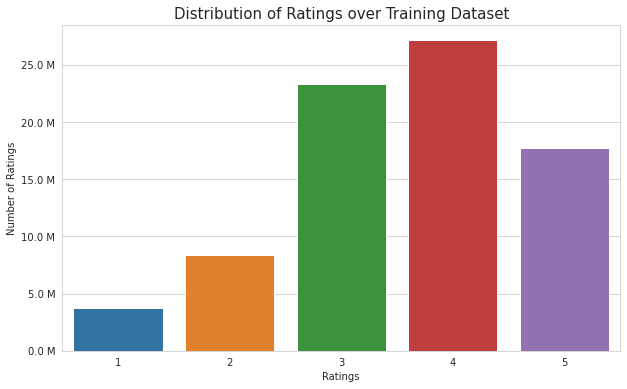

In [ ]:
fig, ax = plt.subplots(figsize = (10, 6))
plt.title('Distribution of Ratings over Training Dataset', fontsize=15)
sns.countplot(x = train_df.rating)
ticks_loc = ax.get_yticks().tolist()
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.xlabel('Ratings')
plt.ylabel('Number of Ratings')
plt.show()



### 2.3.2 Number of ratings on each day of the week
- In the below plot, we can see that the number of ratings given are greater on days like Monday, Tuesday and Wednesday, and are smaller on days like Friday, Saturday and Sunday.
- This may be attributed to the fact that people in US generally perform outdoor activities like trekking, camping, etc, on weekends and/or go in parties.

In [ ]:
# We will be calculating memory usage,so we will create a function to save some resources.
def mem_usage(pandas_obj):
    if isinstance(pandas_obj, pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    # We assume if not a df it's a series
    else:
        usage_b = pandas_obj.memory_usage(deep=True)
        
    # Convert bytes to megabytes
    usage_mb = usage_b / 1024 ** 2 
    return "{:03.2f} MB".format(usage_mb)

In [39]:
# Acquiring the day-name(s) & ratings for analysis.
day_names = train_df.date.dt.day_name()
ratings = train_df['rating']

# Need to clear the RAM in order to run the next few code cells
del train_df
del test_df
gc.collect()

18

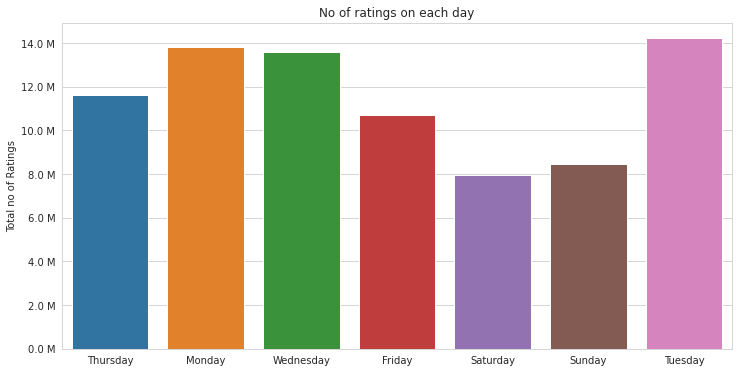

In [ ]:
fig, ax = plt.subplots(figsize = (12, 6))
sns.countplot(x=day_names, ax=ax)
plt.title('No of ratings on each day')
plt.ylabel('Total no of Ratings')
plt.xlabel('')
ticks_loc = ax.get_yticks().tolist()
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()


- Now, we try to see if the day of the week is an important feature to predict the ratings.
- For that, we plotted the boxplots of the ratings across the 7 days of the week, and we found that the boxplots are more or less overlapping.
- In other words, we can say that the day-of-week is not a very useful feature in predicting the ratings. 
- Just to be a bit more sure, we even calculated the average ratings given by users on each of the days, and we found that, they are more or less the same.
- Remember, in Data Science, we perform a lot of experiments and about 90% of them tend of fail. This is why it has the word "Science" in it, i.e., we need to perform a lot of experiments.

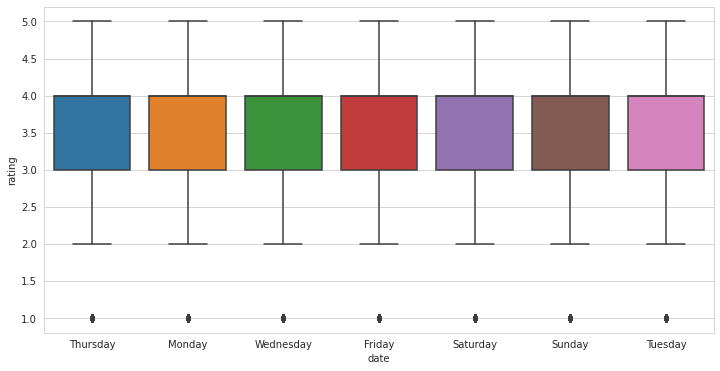

0:01:17.733466


In [ ]:
start = datetime.now()
fig = plt.figure(figsize = (12, 6))
sns.boxplot(y=ratings, x=day_names)
plt.show()
print(datetime.now() - start)

In [40]:
data = {
    'day_of_week': day_names,
    'rating': ratings
}

del day_names
del ratings
gc.collect()

temp_df = pd.DataFrame(data)
del data

In [41]:
avg_week_df = temp_df.groupby(by=['day_of_week'])['rating'].mean()
print("Average Ratings")
print("-"*30)
print(avg_week_df)
print("\n")

Average Ratings
------------------------------
day_of_week
Friday       3.585274
Monday       3.577250
Saturday     3.591791
Sunday       3.594144
Thursday     3.582463
Tuesday      3.574438
Wednesday    3.583751
Name: rating, dtype: float64




In [42]:
# Removing the list from the RAM
del temp_df
gc.collect()

# Reloading the test and train dataframes in the RAM
train_df = pd.read_csv("train.csv", parse_dates = ['date'])
test_df = pd.read_csv("test.csv")

### 2.3.3 Number of Ratings/Month
- In this plot, we can observe that we have data ranging from mid 1999 to mid 2005.
- And we can see, that the number of ratings that we have, increases sharply from around 2003. This is an indication of the growth of Netflix as a company itself.
- And since, we have taken the latest 20% of the ratings in the test data, we can conclude that the test data would be spanning over a very short window of time.

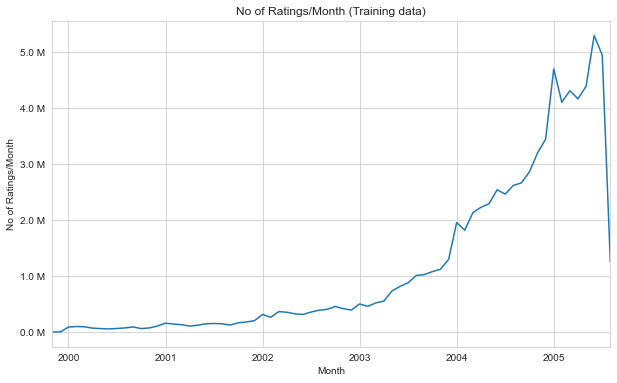

In [43]:
plt.figure(figsize = (10, 6))
ax = train_df.resample('m', on='date')['rating'].count().plot()
ax.set_title('No of Ratings/Month (Training data)')
plt.xlabel('Month')
plt.ylabel('No of Ratings/Month')
ticks_loc = ax.get_yticks().tolist()
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax.set_yticklabels([human(item, 'M') for item in ticks_loc])
plt.show()

### 2.3.4 Analysis on the Ratings given by user
- From the below code cell, we can observe that the maximum number of movies rated by a single user as per our dataset is **17112**, which is pretty huge. So, we got a bit curious, and tried to inspect it a bit more!

In [44]:
no_of_rated_movies_per_user = train_df.groupby(by = 'user')['rating'].count().sort_values(ascending=False)
no_of_rated_movies_per_user.head()

user
305344     17112
2439493    15896
387418     15402
1639792     9767
1461435     9447
Name: rating, dtype: int64

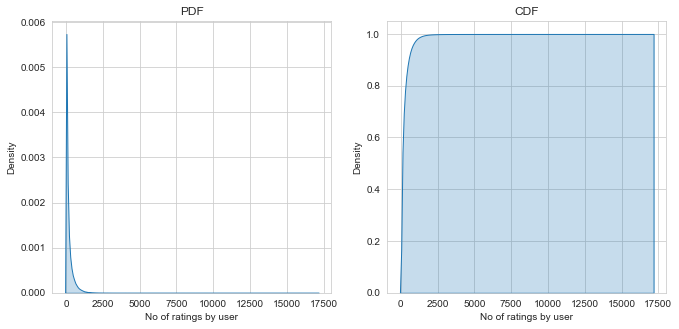

In [45]:
fig = plt.figure(figsize= (11, 5))

ax1 = plt.subplot(121)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, ax=ax1)
plt.xlabel('No of ratings by user')
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, cumulative=True,ax=ax2)
plt.xlabel('No of ratings by user')
plt.title('CDF')

plt.show()

In [46]:
no_of_rated_movies_per_user.describe()

count    405041.000000
mean        198.459921
std         290.793238
min           1.000000
25%          34.000000
50%          89.000000
75%         245.000000
max       17112.000000
Name: rating, dtype: float64

- There is something interesting going on with the quantiles here, as we can see from the above numbers. 
- We observed that there was a huge upsurge from the 75% quantile range to the 100% quantile range. So, we tried to visualize this particular range. 

In [47]:
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

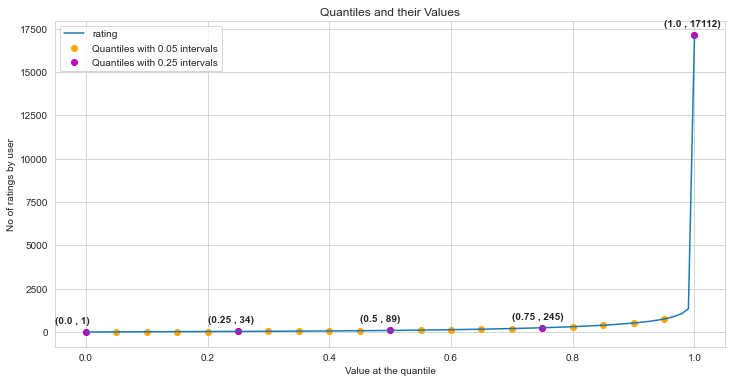

In [48]:
plt.figure(figsize = (12, 6))
plt.title("Quantiles and their Values")
quantiles.plot()

# Quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', 
    label="Quantiles with 0.05 intervals")

# Quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', 
    label="Quantiles with 0.25 intervals")

plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')

# Annotate the 25th, 50th, 75th and 100th percentile values
for x,y in zip(quantiles.index[::25], quantiles[::25]):
    plt.annotate(text="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500), fontweight='bold')

plt.show()

In [49]:
# Printing the Quantile values  
print(quantiles[::5])
print('\nNo of ratings at last 5 percentile : {}\n'.format(sum(no_of_rated_movies_per_user>= 749)))

# From the below numbers, we can see that 5% of our users, have rated more than 749 movies
# And this is a pretty huge number. We will leverage this and other similar kind of conclusions
# while performing feature engineering. 

0.00        1
0.05        7
0.10       15
0.15       21
0.20       27
0.25       34
0.30       41
0.35       50
0.40       60
0.45       73
0.50       89
0.55      109
0.60      133
0.65      163
0.70      199
0.75      245
0.80      307
0.85      392
0.90      520
0.95      749
1.00    17112
Name: rating, dtype: int64

No of ratings at last 5 percentile : 20305



### 2.3.5 Analysis of ratings of a movie given by a user

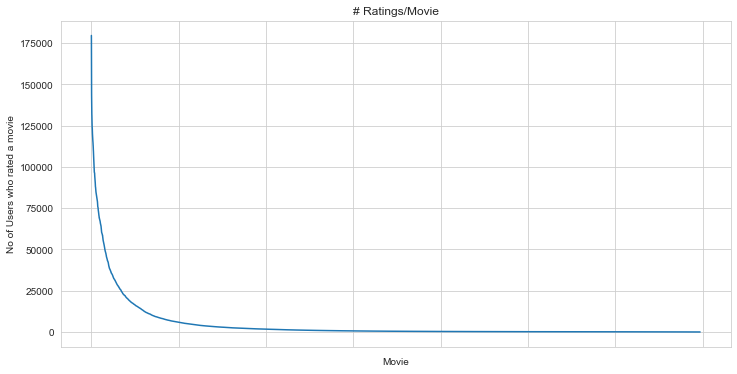

In [50]:
no_of_ratings_per_movie = train_df.groupby(by='movie')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize = (12, 6))
ax = plt.gca()
plt.plot(no_of_ratings_per_movie.values)
plt.title('# Ratings/Movie')
plt.xlabel('Movie')
plt.ylabel('No of Users who rated a movie')
ax.set_xticklabels([])

plt.show()

- It is very skewed, just like the number of ratings given per user.
- There are some movies (which are very popular) which are rated by huge number of users.
- But most of the movies(like 90%) got some hundreds of ratings only.

### 2.3.6 Creating Sparse matrix from Data Frame


#### 2.3.6.1 Creating sparse matrix from train data frame
- In the below code cells, we can see that the sparsity of the training dataset is around 99.82%, which means that only about 0.18% of the cells in the training dataset are filled.

In [51]:
start = datetime.now()
if os.path.isfile('./train_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from the disk!")
    train_sparse_matrix = sparse.load_npz('train_sparse_matrix.npz')
    print("Done")
else: 
    print("We are creating sparse_matrix from the dataframe!")
    # Create sparse_matrix and store it for after usage.
    # csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
    # It should be in such a way that, MATRIX[row, col] = data
    train_sparse_matrix = sparse.csr_matrix((
        train_df.rating.values, (train_df.user.values,train_df.movie.values)
    ))
    
    print('Done. It\'s shape is : (user, movie) : ',train_sparse_matrix.shape)
    print('Saving it into disk for furthur usage!')
    sparse.save_npz("train_sparse_matrix.npz", train_sparse_matrix)
    print('Done\n')
print(datetime.now() - start)



We are creating sparse_matrix from the dataframe!
Done. It's shape is : (user, movie) :  (2649430, 17771)
Saving it into disk for furthur usage!
Done

0:01:08.603363


In [52]:
# The Sparsity of Train Sparse Matrix
us,mv = train_sparse_matrix.shape
elem = train_sparse_matrix.count_nonzero()
print("Sparsity of Train Matrix: {} % ".format(  (1-(elem/(us*mv))) * 100) )
user,movie =train_sparse_matrix.shape

Sparsity of Train Matrix: 99.8292709259195 % 


#### 2.3.6.2 Creating sparse matrix from test data frame
- In the below code cells, we can see that the sparsity of the test dataset is around 99.95%, which means that only about 0.05% of the cells in the test dataset are filled.

In [53]:
start = datetime.now()
if os.path.isfile('./test_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk!")
    test_sparse_matrix = sparse.load_npz('test_sparse_matrix.npz')
    print("Done")
else: 
    print("We are creating sparse_matrix from the dataframe!")
    # Create sparse_matrix and store it for after usage.
    # csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
    # It should be in such a way that, MATRIX[row, col] = data
    test_sparse_matrix = sparse.csr_matrix(
        (test_df.rating.values, (test_df.user.values, test_df.movie.values))
    )
    
    print('Done. It\'s shape is : (user, movie) : ',test_sparse_matrix.shape)
    print('Saving it into disk for furthur usage!')
    sparse.save_npz("test_sparse_matrix.npz", test_sparse_matrix)
    print('Done\n')
print(datetime.now() - start)

We are creating sparse_matrix from the dataframe!
Done. It's shape is : (user, movie) :  (2649430, 17771)
Saving it into disk for furthur usage!
Done

0:00:17.726128


In [54]:
# The Sparsity of Test data Matrix
us,mv = test_sparse_matrix.shape
elem = test_sparse_matrix.count_nonzero()
print("Sparsity of Test Matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )

Sparsity of Test Matrix : 99.95731772988694 % 


### 2.3.7 Finding Global average of all movie ratings, Average rating per user, & Average rating per movie

In [17]:
# Get the user averages in dictionary (key: user_id/movie_id, value: avg rating)
def get_average_ratings(sparse_matrix, of_users):
    # Average ratings of user/movies
    ax = 1 if of_users else 0 # 1 - User axes,0 - Movie axes
    # ".A1" is for converting Row_Matrix to 1-D numpy array 
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    # Boolean matrix of ratings (whether a user rated that movie or not)
    is_rated = (sparse_matrix != 0)
    # No of ratings for each user/movie
    no_of_ratings = is_rated.sum(axis=ax).A1
    # max_user and max_movie ids in sparse matrix 
    u, m = sparse_matrix.shape
    # Create a dictonary of users and their average ratings
    average_ratings = {i : sum_of_ratings[i] / no_of_ratings[i]
         for i in range(u if of_users else m) if no_of_ratings[i] != 0}

    # Return that dictionary of average ratings
    return average_ratings

#### 2.3.7.1 Finding global average of all the ratings

In [59]:
train_averages = dict()
train_global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_averages['global'] = train_global_average
print(train_averages)

{'global': 3.582890686321557}


#### 3.3.7.2 Finding average rating/user

In [60]:
train_averages['user'] = get_average_ratings(train_sparse_matrix, of_users=True)
print('\nAverage rating of user 10:',train_averages['user'][10])


Average rating of user 10: 3.3781094527363185


#### 2.3.7.3 Finding average rating/movie

In [61]:
train_averages['movie'] =  get_average_ratings(train_sparse_matrix, of_users=False)
print('\n Average rating of movie 15:',train_averages['movie'][15])


 Average rating of movie 15: 3.3038461538461537


#### 2.3.7.4 PDF's & CDF's of Avg.Ratings of Users & Movies (In Train Data)
- Since the average ratings of users are in the form of a vector, and since the average ratings of movies are in the form of a vector, hence, we have tried to plot the PDF and CDF for both of them, to get a better sense of them.

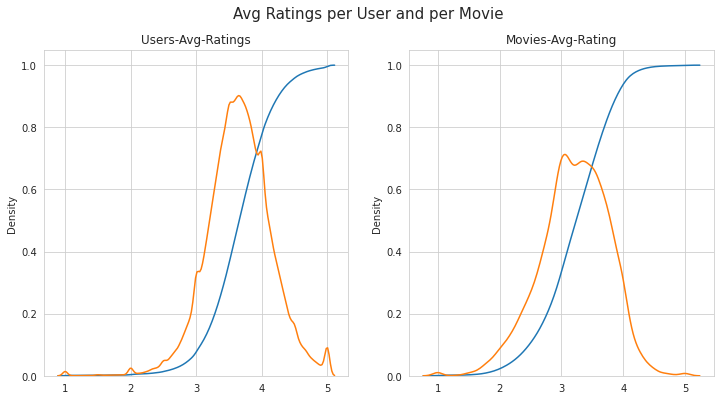

0:00:08.141480


In [ ]:
start = datetime.now()

# Draw PDfs for average rating per user and average
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle('Avg Ratings per User and per Movie', fontsize=15)

# Get the list of average user ratings from the averages dictionary
ax1.set_title('Users-Avg-Ratings')
user_averages = [rat for rat in train_averages['user'].values()]
sns.kdeplot(user_averages, ax=ax1, cumulative=True, label='CDF')
sns.kdeplot(user_averages, ax=ax1, label='PDF')

# Get the list of movie_average_ratings from the dictionary
ax2.set_title('Movies-Avg-Rating')
movie_averages = [rat for rat in train_averages['movie'].values()]
sns.kdeplot(movie_averages, ax=ax2, cumulative=True, label='CDF')
sns.kdeplot(movie_averages, ax=ax2, label='PDF')

plt.show()
print(datetime.now() - start)

### 2.3.8 Cold Start problem
- **Cold Start problem** is something that could seriously hamper our recommendation system. It basically refers to the issue when we encounter new users/movies in our test set, corresponding to which, we don't have the ratings in our training set.

<br>

#### 2.3.8.1 Cold Start problem with Users
- We might have to handle **75148 new users** who didn't appear in train data.
- We might have to handle **346 new movies** (smaller comparatively) in test data.

In [64]:
users_train = len(train_averages['user'])
new_users = total_users - users_train

print('\nTotal number of Users:', total_users)
print('Number of Users in Train data:', users_train)
print("Number of Users that didn't appear in train data: {} ({} %) \n ".format(new_users,
    np.round((new_users/total_users)*100, 2)))

movies_train = len(train_averages['movie'])
new_movies = total_movies - movies_train

print('\nTotal number of Movies  :', total_movies)
print('Number of Users in Train data :', movies_train)
print("Number of Movies that didn't appear in train data: {} ({} %)".format(new_movies,
    np.round((new_movies/total_movies)*100, 2)))


Total number of Users: 480189
Number of Users in Train data: 405041
Number of Users that didn't appear in train data: 75148 (15.65 %) 
 

Total number of Movies  : 17770
Number of Users in Train data : 17424
Number of Movies that didn't appear in train data: 346 (1.95 %)


In [65]:
# Need to clear the RAM in order to run the next few code cells
del train_df
del test_df
gc.collect()

0

## 2.4 Computing Similarity matrices
### 2.4.1 Computing User-User Similarity matrix


#### 2.4.1.1 Trying with all dimensions (17k dimensions per user) 

In [66]:
def compute_user_similarity(sparse_matrix, compute_for_few=False, top = 100, verbose=False, 
    verb_for_n_rows = 20, draw_time_taken=True):
    no_of_users, _ = sparse_matrix.shape
    # Get the indices of  non-zero rows (users) from our sparse matrix
    row_ind, col_ind = sparse_matrix.nonzero()
    # Sorting is not necessary
    row_ind = sorted(set(row_ind))
    # Time taken for finding similar users for an user
    time_taken = list() 
    
    # We create rows, cols, and data lists, that can be used to create sparse matrices.
    rows, cols, data = list(), list(), list()
    if verbose: print("Computing top", top, " similar users for each user")
    
    start = datetime.now()
    temp = 0
    
    for row in row_ind[:top] if compute_for_few else row_ind:
        temp = temp+1
        prev = datetime.now()
        
        # Get the similarity row for this user with all other users
        sim = cosine_similarity(sparse_matrix.getrow(row), sparse_matrix).ravel()
        # We will get only the top ''top'' most similar users and ignore the rest of them.
        top_sim_ind = sim.argsort()[-top:]
        top_sim_val = sim[top_sim_ind]
        
        # Add them to our rows, cols and data
        rows.extend([row]*top)
        cols.extend(top_sim_ind)
        data.extend(top_sim_val)
        time_taken.append(datetime.now().timestamp() - prev.timestamp())
        if verbose:
            if temp%verb_for_n_rows == 0:
                print("Computing done for {} users [  time elapsed : {}  ]"
                      .format(temp, datetime.now()-start))
            
    # Let's create a sparse matrix out of these and return it
    if verbose: print('Creating Sparse matrix from the computed similarities')
    
    if draw_time_taken:
        plt.plot(time_taken, label = 'Time taken for each user')
        plt.plot(np.cumsum(time_taken), label='Total time')
        plt.legend(loc='best')
        plt.xlabel('User')
        plt.ylabel('Time (seconds)')
        plt.show()
      
    return sparse.csr_matrix((data, (rows, cols)), shape=(no_of_users, no_of_users)), time_taken      

Computing top 100  similar users for each user
Computing done for 20 users [  time elapsed : 0:02:00.751037  ]
Computing done for 40 users [  time elapsed : 0:03:54.384181  ]
Computing done for 60 users [  time elapsed : 0:06:08.991011  ]
Computing done for 80 users [  time elapsed : 0:08:04.183310  ]
Computing done for 100 users [  time elapsed : 0:09:39.437582  ]
Creating Sparse matrix from the computed similarities


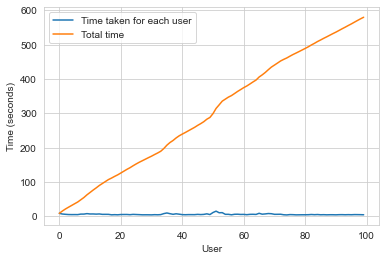

Time taken: 0:09:53.860840


In [67]:
start = datetime.now()
u_u_sim_sparse, _ = compute_user_similarity(train_sparse_matrix, compute_for_few=True, top = 100,
    verbose=True)
print("Time taken:", datetime.now()-start)

#### 2.4.1.2 Trying with reduced dimensions (Using TruncatedSVD for dimensionality reduction of user vector)


In [15]:
# # Initialize the algorithm with some parameters..
# # All of them are default except n_components. n_itr is for Randomized SVD solver.
netflix_svd = TruncatedSVD(n_components=500, algorithm='randomized', random_state=15)
trunc_svd = netflix_svd.fit_transform(train_sparse_matrix)

Here,
- $\sum \longleftarrow$ (netflix\_svd.**singular\_values\_** )
- $\bigvee^T \longleftarrow$ (netflix\_svd.**components_**)
- $\bigcup$ is not returned. instead **Projection_of_X** onto the new vectorspace is returned. 
- It uses **randomized svd** internally, which returns **all 3 of them separately**. Use that instead.

In [ ]:
#expl_var = np.cumsum(netflix_svd.explained_variance_ratio_)

In [ ]:
# # Let's project our Original U_M matrix into into 500 Dimensional space
# trunc_matrix = train_sparse_matrix.dot(netflix_svd.components_.T)


In [ ]:
# Let's convert this to actual sparse matrix and store it for future purposes
# if not os.path.isfile('/trunc_sparse_matrix.npz'):
#     # Create that sparse matrix
#     trunc_sparse_matrix = sparse.csr_matrix(trunc_matrix)
#     # Save this truncated sparse matrix for later usage
#     sparse.save_npz('trunc_sparse_matrix', trunc_sparse_matrix)
# else:
#     trunc_sparse_matrix = sparse.load_npz('trunc_sparse_matrix.npz')
    

(2649430, 500)


In [ ]:
# gc.collect()

# trunc_u_u_sim_matrix, _ = compute_user_similarity(trunc_sparse_matrix, compute_for_few=True, top=50, 
#       verbose=True, verb_for_n_rows=10)


In [ ]:
# # Freeing up the RAM
# del u_u_sim_sparse
# del trunc_sparse_matrix
# del trunc_u_u_sim_matrix
# del _
# gc.collect()

3399

- This is taking more time for each user than the original one. From the above plot, it took almost **50s** for computing simlilar users for **one user**.

 **Why did this happen?** Just think about it, it's not that difficult.
- The reason is because of the differences between Sparse and Dense Matrices. The original matrix was a sparse matrix, and hence computation was much faster for it, but after we used Truncated SVD, though, we got a reduced dimensional matrix, but it was a dense matrix.

- Is there any other way to compute user user similarity?
- An alternative is to compute similar users for a particular user,  whenenver required (**ie., Run time**)
- We maintain a binary vector for users, which tells us whether we already computed for it or not
- **If not**: 
    - Compute top (let's just say, 100) most similar users for this given user, and add this to our datastructure, so that we can just access it (similar users) without recomputing it again.
- **If it is already computed**:
    - Just get it directly from our datastructure, which has that information.
    - In production time, we might have to recompute similarities, if it is computed a long time ago. Because user preferences changes over time. If we could maintain some kind of timer, which when expires, we have to update it (recompute it). 
- **Which datastructure to use**:
    - It is purely implementation dependent 
    - One simple method is to maintain a **Dictionary Of Dictionaries**.
        - **key**  : *userid* 
        - **value**: *Again a dictionary*
            - **key**  : *Similar User*
            - **value**: *Similarity Value*
                  
### 2.4.2 Computing Movie-Movie Similarity matrix 

In [4]:
train_sparse_matrix = sparse.load_npz('train_sparse_matrix.npz')
start = datetime.now()
if not os.path.isfile('/m_m_sim_sparse.npz'):
    print("It seems you don't have that file. Computing movie_movie similarity")
    start = datetime.now()
    m_m_sim_sparse = cosine_similarity(X=train_sparse_matrix.T, dense_output=False)
    print("Done")
    # Store this sparse matrix in disk before using it. For future purposes.
    print("Saving it to disk without the need of re-computing it again")
    sparse.save_npz("m_m_sim_sparse.npz", m_m_sim_sparse)
    print("Done")
else:
    m_m_sim_sparse = sparse.load_npz("m_m_sim_sparse.npz")
    print("Done")

print("It's a ", m_m_sim_sparse.shape," dimensional matrix")
print(datetime.now() - start)


It seems you don't have that file. Computing movie_movie similarity
Done
Saving it to disk without the need of re-computing it again
Done
It's a  (17771, 17771)  dimensional matrix
0:14:27.472082


- Even though we have similarity measure of each movie, with all other movies, We generally don't care much about least similar movies.
- Most of the times, only top_xxx similar items matters. It may be 10 or 100.
- We take only those top similar movie ratings and store them  in a saperate dictionary.

In [5]:
movie_ids = np.unique(m_m_sim_sparse.nonzero()[1])

In [6]:
start = datetime.now()
similar_movies = dict()
for movie in movie_ids:
    # Get the top similar movies and store them in the dictionary
    sim_movies = m_m_sim_sparse[movie].toarray().ravel().argsort()[::-1][1:]
    similar_movies[movie] = sim_movies[:100]
print(datetime.now() - start)

# Just testing similar movies for movie_15
similar_movies[15]

0:01:09.064372


array([ 8279,  8013, 16528,  5927, 13105, 12049,  4424, 10193, 17590,
        4549,  3755,   590, 14059, 15144, 15054,  9584,  9071,  6349,
       16402,  3973,  1720,  5370, 16309,  9376,  6116,  4706,  2818,
         778, 15331,  1416, 12979, 17139, 17710,  5452,  2534,   164,
       15188,  8323,  2450, 16331,  9566, 15301, 13213, 14308, 15984,
       10597,  6426,  5500,  7068,  7328,  5720,  9802,   376, 13013,
        8003, 10199,  3338, 15390,  9688, 16455, 11730,  4513,   598,
       12762,  2187,   509,  5865,  9166, 17115, 16334,  1942,  7282,
       17584,  4376,  8988,  8873,  5921,  2716, 14679, 11947, 11981,
        4649,   565, 12954, 10788, 10220, 10963,  9427,  1690,  5107,
        7859,  5969,  1510,  2429,   847,  7845,  6410, 13931,  9840,
        3706], dtype=int64)

### 2.4.3 Finding most similar movies using similarity matrix
- Does Similarity really works as the way we expected? 
- Let's pick some random movie and check for its similar movies.

In [7]:
# First let's load the movie details into soe dataframe

movie_titles = pd.read_csv("movie_titles.csv", sep=',', header = None,
    names=['movie_id', 'year_of_release', 'title'], verbose=True, index_col = 'movie_id', encoding = "ISO-8859-1")
movie_titles.head()

Tokenization took: 16.06 ms
Type conversion took: 40.18 ms
Parser memory cleanup took: 0.00 ms


,year_of_release,title
movie_id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


In [8]:
# Similar Movies for 'Vampire Journals'
mv_id = 67
print("Movie - ", movie_titles.loc[mv_id].values[1])
print("It has {} ratings from users.".format(train_sparse_matrix[:,mv_id].getnnz()))
print("We have {} movies which are similar to this  and we will get only top most".format(m_m_sim_sparse[:,mv_id].getnnz()))

Movie -  Vampire Journals
It has 270 ratings from users.
We have 17284 movies which are similar to this  and we will get only top most


In [9]:
similarities = m_m_sim_sparse[mv_id].toarray().ravel()
similar_indices = similarities.argsort()[::-1][1:]
similarities[similar_indices]

# It will sort and reverse the array and ignore its similarity (ie.,1) 
# and return it's indices(movie_ids)

array([0.21032399, 0.17629207, 0.17608115, ..., 0.        , 0.        ,
       0.        ])

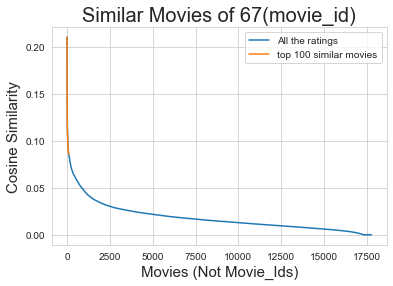

In [11]:
plt.plot(similarities[similar_indices], label='All the ratings')
plt.plot(similarities[similar_indices[:100]], label='top 100 similar movies')
plt.title("Similar Movies of {}(movie_id)".format(mv_id), fontsize=20)
plt.xlabel("Movies (Not Movie_Ids)", fontsize=15)
plt.ylabel("Cosine Similarity",fontsize=15)
plt.legend()
plt.show()

In [12]:
# Top 10 similar movies
movie_titles.loc[similar_indices[:10]]

# Similarly, we can ___find similar users___ and compare how similar they are. 

,year_of_release,title
movie_id,,
323,1999.0,Modern Vampires
4044,1998.0,Subspecies 4: Bloodstorm
1688,1993.0,To Sleep With a Vampire
13962,2001.0,Dracula: The Dark Prince
12053,1993.0,Dracula Rising
16279,2002.0,Vampires: Los Muertos
4667,1996.0,Vampirella
1900,1997.0,Club Vampire
13873,2001.0,The Breed


# Matrix Factorization Techniques

In [7]:

train_df=pd.read_csv('train.csv')
sample_train_df=train_df[:10000000]
reader = Reader(rating_scale=(1, 5))
# Create the traindata from the dataframe
train_data = Dataset.load_from_df(sample_train_df[['user', 'movie', 'rating']], reader)
# Build the trainset from traindata, it is of dataset format from surprise library
trainset = train_data.build_full_trainset() 
del train_df
gc.collect()

0

In [8]:
test_df=pd.read_csv('test.csv')
sample_test_df=test_df[:2500000]
testset = list(zip(sample_test_df.user.values,sample_test_df.movie.values,sample_test_df.rating.values))  
del test_df
gc.collect()

0

In [9]:
models_evaluation_train = dict()
models_evaluation_test = dict() 


In [10]:
# Utility functions for Surprise modes

# It is just to makesure that all of our algorithms should produce same results everytime they run
my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

# Get  (actual_list , predicted_list) ratings given list of predictions 
# (Prediction is a class in Surprise).    
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    return actual, pred

# Get RMSE and MAPE, given list of prediction objecs 
def get_errors(predictions, print_them=False):
    actual, pred = get_ratings(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)
    return rmse, mape*100

# It will return predicted ratings, RMSE and MAPE of both train and test data
def run_surprise(algo, trainset, testset, verbose=True): 
    '''
    return train_dict, test_dict
    It returns two dictionaries, one for train and the other is for test
    Each of them have 3 key-value pairs, which specify RMSE, MAPE and `predicted ratings`.
    '''
    start = datetime.now()
    # Dictionaries that stores metrics for train and test
    train = dict()
    test = dict()
    
    # Train the algorithm with the trainset
    st = datetime.now()
    print('Training the model')
    algo.fit(trainset)
    print('Done. Time taken: {}'.format(datetime.now()-st))
    
    # Evaluating train data
    st = datetime.now()
    print('Evaluating the model with train data')
    # Get the train predictions (list of prediction class inside Surprise)
    train_preds = algo.test(trainset.build_testset())
    # Get predicted ratings from the train predictions
    train_actual_ratings, train_pred_ratings = get_ratings(train_preds)
    # Get RMSE and MAPE from the train predictions
    train_rmse, train_mape = get_errors(train_preds)
    print('Time taken: {}'.format(datetime.now()-st))
  
    if verbose:
        print('-'*15)
        print('Train Data')
        print('-'*15)
        print("RMSE: {}\nMAPE: {}".format(train_rmse, train_mape))
    
    # Store them in the train dictionary
    if verbose:
        print('Adding train results in the dictionary')
    train['rmse'] = train_rmse
    train['mape'] = train_mape
    train['predictions'] = train_pred_ratings
    
    # Evaluating Test data
    st = datetime.now()
    print('Evaluating for test data')
    # Get the predictions (list of prediction classes) of test data
    test_preds = algo.test(testset)
    # Get the predicted ratings from the list of predictions
    test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
    # Get error metrics from the predicted and actual ratings
    test_rmse, test_mape = get_errors(test_preds)
    print('Time taken: {}'.format(datetime.now()-st))
    
    
    if verbose:
        print('-'*15)
        print('Test Data')
        print('-'*15)
        print("RMSE : {}\nMAPE : {}".format(test_rmse, test_mape))
    # Store them in test dictionary
    if verbose:
        print('storing the test results in test dictionary...')
    test['rmse'] = test_rmse
    test['mape'] = test_mape
    test['predictions'] = test_pred_ratings
    
    print('\n'+'-'*45)
    print('Total time taken to run this algorithm: ', datetime.now() - start)
    
    # Return two dictionaries train and test
    return train, test


#### 3.1 SVD Matrix Factorization User Movie Interactions


In [14]:
# Initialize the model
svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True)
svd_train_results, svd_test_results = run_surprise(svd, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svd'] = svd_train_results 
models_evaluation_test['svd'] = svd_test_results


Training the model
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Done. Time taken: 0:04:00.937926
Evaluating the model with train data
Time taken: 0:04:56.719954
---------------
Train Data
---------------
RMSE: 0.7312009577169861
MAPE: 22.83490582665477
Adding train results in the dictionary
Evaluating for test data
Time taken: 0:02:35.780551
---------------
Test Data
---------------
RMSE : 1.1006367120170477
MAPE : 32.7205396698921
storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm:  0:11:33.479828


#### 3.2 SVD Matrix Factorization with implicit feedback from user ( user rated movies )


In [ ]:
# Initialize the model
svdpp = SVDpp(n_factors=50, random_state=15, verbose=True)
svdpp_train_results, svdpp_test_results = run_surprise(svdpp, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svdpp'] = svdpp_train_results 
models_evaluation_test['svdpp'] = svdpp_test_results

#### 3.3 KNN Baseline


In [15]:
# We specify, how to compute similarities and what to consider with sim_options to our algorithm
# 'user_based' : False; This considers the similarities of movies instead of users
sim_options = {'user_based' : False, 'name': 'pearson_baseline', 'shrinkage': 100, 'min_support': 2}

# We keep other parameters like regularization parameter and learning_rate as default values
bsl_options = {'method': 'sgd'}

knn_bsl_m = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)
knn_bsl_m_train_results, knn_bsl_m_test_results = run_surprise(knn_bsl_m, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_m'] = knn_bsl_m_train_results 
models_evaluation_test['knn_bsl_m'] = knn_bsl_m_test_results


Training the model
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. Time taken: 0:23:46.095451
Evaluating the model with train data
Time taken: 1:29:39.589913
---------------
Train Data
---------------
RMSE: 0.6749931295128279
MAPE: 21.287334159299533
Adding train results in the dictionary
Evaluating for test data
Time taken: 0:01:46.762459
---------------
Test Data
---------------
RMSE : 1.096174178137659
MAPE : 32.874919669767735
storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm:  1:55:12.495838


# XGBoost 


## Featurizing data

### Build sample dataset


In [2]:
def get_sample_sparse_matrix(sparse_matrix, no_users, no_movies, path, verbose = True):
    """
    It will get it from the ''path'' if it is present  or it will create 
    and store the sampled sparse matrix in the path specified.
    """
    # Get (row, col) and (rating) tuple from sparse_matrix.
    row_ind, col_ind, ratings = sparse.find(sparse_matrix)
    users = np.unique(row_ind)
    movies = np.unique(col_ind)

    print("Original Matrix: (users, movies) -- ({} {})".format(len(users), len(movies)))
    print("Original Matrix: Ratings -- {}\n".format(len(ratings)))

    # It's just to make sure to get same sample everytime we run this program & pick without replacement
    np.random.seed(15)
    sample_users = np.random.choice(users, no_users, replace=False)
    sample_movies = np.random.choice(movies, no_movies, replace=False)
    
    # Get the boolean mask of these sampled_items in originl row/col_inds.
    mask = np.logical_and(np.isin(row_ind, sample_users), np.isin(col_ind, sample_movies))
    
    sample_sparse_matrix = sparse.csr_matrix((ratings[mask], (row_ind[mask], col_ind[mask])),
         shape=(max(sample_users)+1, max(sample_movies)+1))

    if verbose:
        print("Sampled Matrix : (users, movies) -- ({} {})".format(len(sample_users), len(sample_movies)))
        print("Sampled Matrix : Ratings --", format(ratings[mask].shape[0]))

    print('Saving it into disk for furthur usage!')
    # save it into disk
    sparse.save_npz(path, sample_sparse_matrix)
    if verbose:
            print('Done')
    
    return sample_sparse_matrix

In [8]:

path='./sample_train_sparse_maxtrix.npz'
if os.path.isfile(path):
    sample_train_sparse_matrix= sparse.load_npz('sample_train_sparse_maxtrix.npz')

else:
    sample_train_sparse_matrix = get_sample_sparse_matrix(train_sparse_matrix, no_users=10000, no_movies=1000, path=path)

Original Matrix: (users, movies) -- (405041 17424)
Original Matrix: Ratings -- 80384405

Sampled Matrix : (users, movies) -- (10000 1000)
Sampled Matrix : Ratings -- 129286
Saving it into disk for furthur usage!
Done


In [10]:

path='./sample_test_sparse_matirx.npz'
if os.path.isfile(path):
    sample_test_sparse_matrix= sparse.load_npz(path)
else:
    sample_test_sparse_matrix= get_sample_sparse_matrix(test_sparse_matrix, no_users = 10000, no_movies=1000,path=path)

Original Matrix: (users, movies) -- (349312 17757)
Original Matrix: Ratings -- 20096102

Sampled Matrix : (users, movies) -- (10000 1000)
Sampled Matrix : Ratings -- 36017
Saving it into disk for furthur usage!
Done


### Find average

In [14]:
sample_train_averages = dict()

In [15]:
global_average = sample_train_sparse_matrix.sum()/sample_train_sparse_matrix.count_nonzero()
sample_train_averages['global'] = global_average
print(sample_train_averages)

{'global': 3.581679377504138}


In [18]:
sample_train_averages['user'] = get_average_ratings(sample_train_sparse_matrix, of_users=True)
print('Average rating of user 1515220:', sample_train_averages['user'][1515220])

Average rating of user 1515220: 3.9655172413793105


In [24]:
sample_train_averages['movie'] = get_average_ratings(sample_train_sparse_matrix,of_users=False)
print('Average rating of movie 15153:', sample_train_averages['movie'][15153])

Average rating of movie 15153: 2.6458333333333335


In [25]:
print('No of ratings in Our Sampled train matrix is : {}\n'.format(sample_train_sparse_matrix.count_nonzero()))
print('No of ratings in Our Sampled test  matrix is : {}\n'.format(sample_test_sparse_matrix.count_nonzero()))

No of ratings in Our Sampled train matrix is : 129286

No of ratings in Our Sampled test  matrix is : 36017



### Featurizing train data

In [27]:
# Get users, movies and ratings from our samples train sparse matrix
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_train_sparse_matrix)

In [29]:
start = datetime.now()
if os.path.isfile('./reg_train.csv'):
    print("File already exists you don't have to prepare again!")
else:
    print('Preparing {} tuples for the dataset'.format(len(sample_train_ratings)))
    with open('reg_train.csv', mode='w') as reg_data_file:
        count = 0
        for (user, movie, rating)  in zip(sample_train_users, sample_train_movies, sample_train_ratings):
            st = datetime.now()
            # =============================================
            # Ratings of "movie" by similar users of "user"
            # =============================================
            
            # Compute the similar Users of the "user"        
            user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
            # We are ignoring 'The User' from its similar users
            top_sim_users = user_sim.argsort()[::-1][1:] 
            # Get the ratings of most similar users for this movie
            top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
            # We will make it's length "5" by adding movie averages to the rest of the cells.
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))

            # ==============================================
            # Ratings by "user"  to similar movies of "movie"
            # ==============================================
            
            # Compute the similar movies of the "movie"        
            movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
            # We are ignoring 'The Movie' from its similar movies.
            top_sim_movies = movie_sim.argsort()[::-1][1:] 
            # Get the ratings of most similar movie rated by this user
            top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
            # We will make it's length "5" by adding user averages to the rest of the cells
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
    
            # ======================================
            # Prepare the row to be stores in a file
            # ======================================
            
            row = list()
            row.append(user)
            row.append(movie)
            # Now add the other features to this data; First Feature
            row.append(sample_train_averages['global']) 
            # Next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            # Next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            # Avg_user rating
            row.append(sample_train_averages['user'][user])
            # Avg_movie rating
            row.append(sample_train_averages['movie'][movie])

            # Finally, the actual rating of this user-movie pair
            row.append(rating)
            count = count + 1

            # Add rows to the file opened
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%10000 == 0:
                print("Done for {} rows - {}".format(count, datetime.now() - start))

print(datetime.now() - start)

File already exists you don't have to prepare again!
0:00:00.002964


### Featurizing test data

In [30]:
# Get users, movies and ratings from the Sampled Test 
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(sample_test_sparse_matrix)

In [40]:
start = datetime.now()
if os.path.isfile('./reg_test.csv'):
    print("It is already created!")
else:
    print('Preparing {} tuples for the dataset..\n'.format(len(sample_test_ratings)))
    with open('reg_test.csv', mode='w') as reg_data_file:
        count = 0 
        for (user, movie, rating)  in zip(sample_test_users, sample_test_movies, sample_test_ratings):
            st = datetime.now()
            # =============================================
            # Ratings of "movie" by similar users of "user"
            # =============================================   
            try:
                # Compute the similar Users of the "user"        
                user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
                # We are ignoring 'The User' from its similar users.
                top_sim_users = user_sim.argsort()[::-1][1:] 
                # Get the ratings of most similar users for this movie
                top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
                # We will make it's length "5" by adding movie averages to .
                top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))

            except (IndexError, KeyError):
                # It is a new User or new Movie or there are no ratings for given user for top similar movies
                # Cold STart Problem
                top_sim_users_ratings.extend([sample_train_averages['global']]*(5 - len(top_sim_users_ratings)))
            except:
                # We just want KeyErrors to be resolved. Not every Exception...
                print(user, movie)
                raise

            # ==============================================
            # Ratings by "user"  to similar movies of "movie"
            # ==============================================

            try:
                # Compute the similar movies of the "movie"        
                movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
                # We are ignoring 'The Movie' from its similar movies.
                top_sim_movies = movie_sim.argsort()[::-1][1:] 
                # Get the ratings of most similar movie rated by this user
                top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
                # We will make it's length "5" by adding user averages to the rest of the cells
                top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
            except (IndexError, KeyError):
                top_sim_movies_ratings.extend([sample_train_averages['global']]*(5-len(top_sim_movies_ratings)))
            except :
                raise

            # =======================================
            # Prepare the row to be stores in a file
            # =======================================
            
            row = list()
            # Add user and movie name first
            row.append(user)
            row.append(movie)
            # First feature
            row.append(sample_train_averages['global']) 
            # Next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            # Next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            # Avg_user rating
            try:
                row.append(sample_train_averages['user'][user])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            # Avg_movie rating
            try:
                row.append(sample_train_averages['movie'][movie])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            # Finally, the actual rating of this user-movie pair
            row.append(rating)
            count = count + 1

            # Add rows to the file opened
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%1000 == 0:
                print("Done for {} rows - {}".format(count, datetime.now() - start))
    print("",datetime.now() - start)

    

It is already created!


## Modeling 

In [4]:
reg_train = pd.read_csv('./reg_train.csv', names = ['user', 'movie', 'GAvg', 'sur1', 
    'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating'], 
    header=None
)
reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,5.0,3.0,1.0,3.370370,4.092437,4
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,4.0,3.0,5.0,3.555556,4.092437,3
2,99865,33,3.581679,5.0,5.0,4.0,5.0,3.0,5.0,4.0,4.0,5.0,4.0,3.714286,4.092437,5
3,101620,33,3.581679,2.0,3.0,5.0,5.0,4.0,4.0,3.0,3.0,4.0,5.0,3.584416,4.092437,5
4,112974,33,3.581679,5.0,5.0,5.0,5.0,5.0,3.0,5.0,5.0,5.0,3.0,3.750000,4.092437,5


- __GAvg__ : Average rating of all the ratings 
- __Similar users rating of this movie__:
    - sur1, sur2, sur3, sur4, sur5 (Top 5 similar users who rated that movie)
- __Similar movies rated by this user__:
    - smr1, smr2, smr3, smr4, smr5 (Top 5 similar movies rated by this user)
- __UAvg__ : User's Average rating
- __MAvg__ : Average rating of this movie
- __rating__ : Rating of this movie by this user.

In [8]:
# Reading from the file to make a test dataframe
reg_test_df = pd.read_csv('./reg_test.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2',
'sur3', 'sur4', 'sur5', 'smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating'], header=None)
reg_test_df.head(4)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,5
1,898730,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3
2,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4
3,1280761,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,1


In [42]:
# It is to specify how to read the dataframe.
# For our dataframe, we don't have to specify anything extra
reader = Reader(rating_scale=(1, 5))

# Create the traindata from the dataframe
train_data = Dataset.load_from_df(reg_train[['user', 'movie', 'rating']], reader)

# Build the trainset from traindata, it is of dataset format from surprise library
trainset = train_data.build_full_trainset() 

In [43]:
testset = list(zip(reg_test_df.user.values, reg_test_df.movie.values, reg_test_df.rating.values))
testset[:3]

[(808635, 71, 5), (898730, 71, 3), (941866, 71, 4)]

In [14]:
models_evaluation_train = dict()
models_evaluation_test = dict()
models_evaluation_train, models_evaluation_test

({}, {})

In [13]:
def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
    mape = np.mean(np.abs( (y_true - y_pred)/ y_true )) * 100
    return rmse, mape

def run_xgboost(algo,  x_train, y_train, x_test, y_test, verbose=True):
    # Dictionaries for storing train and test results
    train_results = dict()
    test_results = dict()
    
    # Fit the model
    print('Training the model')
    start = datetime.now()
    algo.fit(x_train, y_train, eval_metric = 'rmse')
    print('Done. Time taken : {}'.format(datetime.now()-start))

    # From the trained model, get the predictions
    print('Evaluating the model with TRAIN data')
    start = datetime.now()
    y_train_pred = algo.predict(x_train)
    # Get the RMSE and MAPE of train data
    rmse_train, mape_train = get_error_metrics(y_train.values, y_train_pred)
    if verbose:
        print('-'*15)
        print('Train Data')
        print('-'*15)
        print("RMSE: {}\nMAPE: {}".format(rmse_train, mape_train))
    
    # Store the results in train_results dictionary
    train_results = {'rmse': rmse_train, 'mape' : mape_train, 'predictions' : y_train_pred}
    
    # Get the test data predictions and compute RMSE and MAPE
    print('Evaluating Test data')
    y_test_pred = algo.predict(x_test) 
    rmse_test, mape_test = get_error_metrics(y_true=y_test.values, y_pred=y_test_pred)
    # Store them in our test results dictionary
    test_results = {'rmse': rmse_test, 'mape' : mape_test, 'predictions':y_test_pred}
    if verbose:
        print('-'*15)
        print('Test Data')
        print('-'*15)
        print('RMSE: ', rmse_test)
        print('MAPE: ', mape_test)
        
    # Return these train and test results
    return train_results, test_results

Training the model
[16:59:08] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.



c:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Done. Time taken : 0:00:02.477977
Evaluating the model with TRAIN data
---------------
Train Data
---------------
RMSE: 0.595563456425939
MAPE: 16.70881727240123
Evaluating Test data
---------------
Test Data
---------------
RMSE:  1.1200549395432895
MAPE:  33.83961570161242


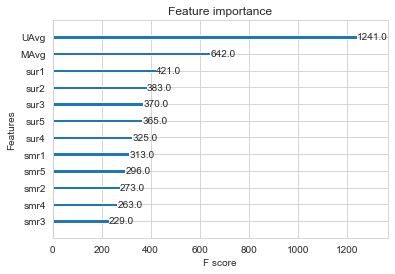

In [46]:
# Prepare Train data
x_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# Initialize Our first XGBoost model
first_xgb = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=100)
train_results, test_results = run_xgboost(first_xgb, x_train, y_train, x_test, y_test)

# Store the results in models_evaluations dictionaries
models_evaluation_train['first_algo'] = train_results
models_evaluation_test['first_algo'] = test_results

xgb.plot_importance(first_xgb)
plt.show()

In [53]:
# Preparing Train data
# Add the predicted values from both knns to this dataframe
reg_train['svd'] = models_evaluation_train['svd']['predictions']
reg_train['svdpp'] = models_evaluation_train['svdpp']['predictions']
reg_train.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,svd,svdpp
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,5.0,3.0,1.0,3.370370,4.092437,4,4.197043,3.815752
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,4.0,3.0,5.0,3.555556,4.092437,3,3.063828,3.113076


In [54]:
# Preparing Test data
reg_test_df['svd'] = models_evaluation_test['svd']['predictions']
reg_test_df['svdpp'] = models_evaluation_test['svdpp']['predictions']
reg_test_df.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,svd,svdpp
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,5,3.487104,3.487104
1,898730,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3,3.487104,3.487104


Training the model


c:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Done. Time taken : 0:00:02.293655
Evaluating the model with TRAIN data
---------------
Train Data
---------------
RMSE: 0.5665129872588599
MAPE: 16.063894110901874
Evaluating Test data
---------------
Test Data
---------------
RMSE:  1.0916600989609397
MAPE:  35.125507325101644


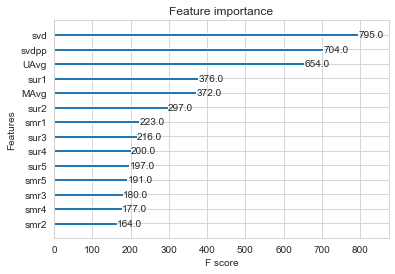

In [55]:
# Prepare x_train and y_train
x_train = reg_train.drop(['user', 'movie', 'rating',], axis=1)
y_train = reg_train['rating']

# Prepare test data
x_test = reg_test_df.drop(['user', 'movie', 'rating'], axis=1)
y_test = reg_test_df['rating']

xgb_final = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_final, x_train, y_train, x_test, y_test)

# Store the results in models_evaluations dictionaries
models_evaluation_train['xgb_final'] = train_results
models_evaluation_test['xgb_final'] = test_results

xgb.plot_importance(xgb_final)
plt.show()

In [56]:
# Saving our TEST_RESULTS into a dataframe so that you don't have to run it again
pd.DataFrame(models_evaluation_test).to_csv('small_sample_results.csv')
models = pd.read_csv('./small_sample_results.csv', index_col=0)
models.loc['rmse'].sort_values()

svdpp         1.0897266245910153
svd           1.0899126686574399
knn_bsl_m     1.0899356151411084
xgb_final     1.0916600989609397
first_algo    1.1200549395432895
Name: rmse, dtype: object

## Xgboost vs Logistic Regression

In [7]:
reg_train_new = reg_train.loc[:,['user', 'movie','UAvg', 'MAvg', 'rating']]
reg_train_new.head()

,user,movie,UAvg,MAvg,rating
0,53406,33,3.370370,4.092437,4
1,99540,33,3.555556,4.092437,3
2,99865,33,3.714286,4.092437,5
3,101620,33,3.584416,4.092437,5
4,112974,33,3.750000,4.092437,5


In [10]:

reg_test_new = reg_test_df.loc[:,['user', 'movie','UAvg', 'MAvg', 'rating']]
reg_test_new.head()

,user,movie,UAvg,MAvg,rating
0,808635,71,3.581679,3.581679,5
1,898730,71,3.581679,3.581679,3
2,941866,71,3.581679,3.581679,4
3,1280761,71,3.581679,3.581679,1
4,1386925,71,3.581679,3.581679,3


In [11]:
reader=Reader(rating_scale=(1,5))
train_data_new= Dataset.load_from_df(reg_train_new[['user','movie','rating']],reader=reader)
trainset=train_data_new.build_full_trainset()

In [12]:
testset = list(zip(reg_test_new.user.values, reg_test_new.movie.values, reg_test_new.rating.values))
testset[:3]

[(808635, 71, 5), (898730, 71, 3), (941866, 71, 4)]

Training the model
[09:15:04] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.



c:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Done. Time taken : 0:00:01.033567
Evaluating the model with TRAIN data
---------------
Train Data
---------------
RMSE: 0.7604869812746662
MAPE: 22.78107643306698
Evaluating Test data
---------------
Test Data
---------------
RMSE:  1.0909642459993458
MAPE:  36.51079582328741


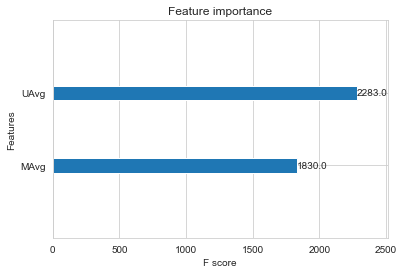

In [15]:
# Prepare Train data
x_train = reg_train_new.drop(['user','movie','rating'], axis=1)
y_train = reg_train_new['rating']

# Prepare Test data
x_test = reg_test_new.drop(['user','movie','rating'], axis=1)
y_test = reg_test_new['rating']

# Initialize Our first XGBoost model
xgb_new = xgb.XGBRegressor(silent=False, n_jobs=-1, random_state=15, n_estimators=100)
train_results, test_results = run_xgboost(xgb_new, x_train, y_train, x_test, y_test)

# Store the results in models_evaluations dictionaries
models_evaluation_train['XGB_New'] = train_results
models_evaluation_test['XGB_New'] = test_results

xgb.plot_importance(xgb_new)
plt.show()

In [21]:
from sklearn.linear_model import LogisticRegression

LR=LogisticRegression()
LR.fit(x_train, y_train)
y_pred = LR.predict(x_test)

def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
    mape = np.mean(np.abs( (y_true - y_pred)/ y_true )) * 100
    print('RMSE:',rmse,'\n','MAPE:',mape)
get_error_metrics(y_test,y_pred)



RMSE: 1.1586694826653028 
 MAPE: 38.5391036109599


c:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Evaluation Metrics

In [11]:


svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True)
svd.fit(trainset)
test_preds = svd.test(testset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19


In [57]:
test_actual_ratings, test_pred_ratings = get_ratings(test_preds)


In [97]:
len(test_pred_ratings)

2500000

In [64]:
test_actual_ratings

array([2, 4, 5, ..., 4, 5, 5], dtype=int64)

In [73]:
mape = np.mean(np.abs(test_pred_ratings - test_actual_ratings)/test_actual_ratings)
print(mape)

0.32720539669892096


In [92]:
rmse = np.sqrt(np.mean((test_pred_ratings - test_actual_ratings)**2))
rmse

1.1006367120170477

In [80]:
from collections import defaultdict

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls


precisions, recalls = precision_recall_at_k(test_preds, k=20, threshold=4)

# Precision and recall can then be averaged over all users
print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))

0.19600090153410674
0.05536122814810401
